# COVID-19 Outcome Modeling


# TODO:

MLP

- Data analysis
- Data preprocessing and normalization
- Data split
- Configuration
- Experiment tracking
- Experiments - meaningful based on the results of previous experiments
- Including improvement techniques (e.g. Dropout, Normalization layers, Skip Connections, Bottleneck Layers, …)
- Hyperparameter search (grid/random) / sweep #optional
- Results and evaluation metrics
- Clear code
- Markdown documentation and comments
- Final presentation of projects
- Effort on consultations

# OUR TODO:

- download dataset using pandas ? easier because of we can just use link but maybe everyone will use pandas -done
- good enough data analysis that is seen in jupyter notebook, not just from reading dataset - done
- correlation chart - chart of correlation of columns between themselves - done
- outliers - what to do with them ?
- counts of data in each column and plots of them -done
- normalize age 0-1 young/old ? min max or z score, mean have 0 deviation has 1
- warning if something has 100% correlation we should do something with it
- better -1 is False; 0 - not state /dont know; 1 - True
- think about combining weird features or if 20% are not state try to remove them
- vantby tracking experiments
- focus on binary prediction with binary cross entropy on only testing (zamerane na binarnu predikciu binary cross entropy na testovacej dat metriky netrenujem )
- datasplit for training validation and testing DF 70 10 20 and check if decreasing both training and validation loss

End-to-end pipeline covering EDA, preprocessing, stratified splits, imbalance-aware PyTorch models, experiment tracking, and final evaluation.


In [1]:
import warnings
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.display import display
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
torch.manual_seed(42)
np.random.seed(42)


In [2]:
DATA_PATH = Path("dataset.csv")
BATCH_SIZE = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cpu


Shape of dataset: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

,count
USMER,1048575
MEDICAL_UNIT,1048575
SEX,1048575
PATIENT_TYPE,1048575
INTUBED,1048575
PNEUMONIA,1048575
AGE,1048575
PREGNANT,1048575
DIABETES,1048575
COPD,1048575


Dataset shape: (1048575, 21)


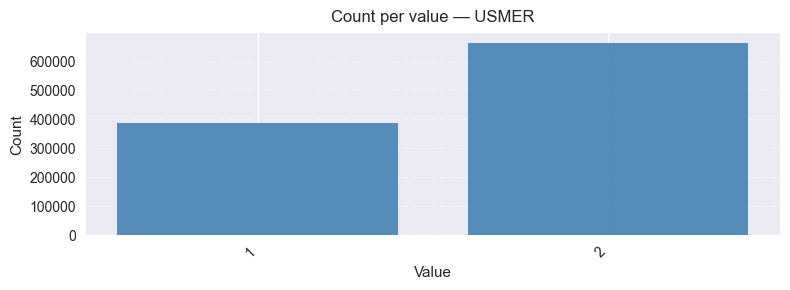

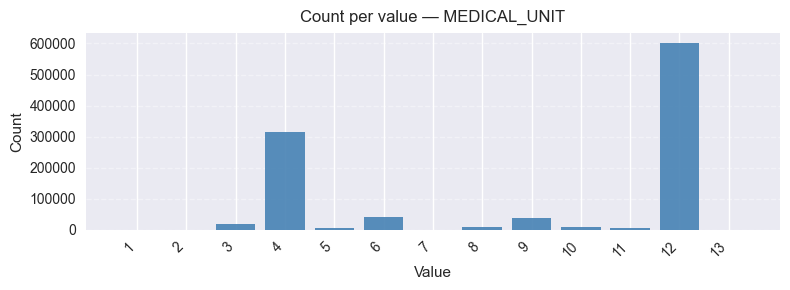

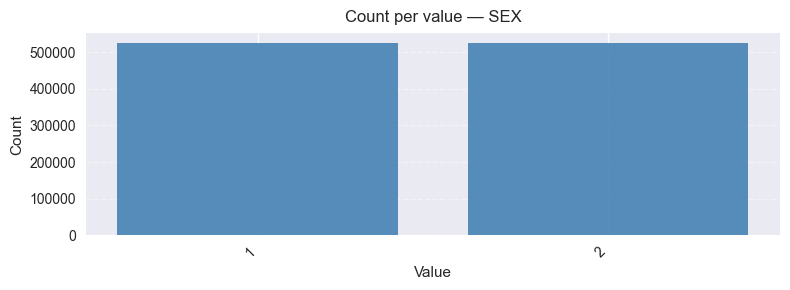

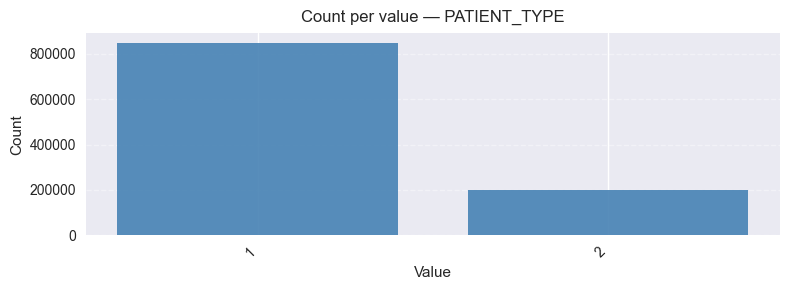

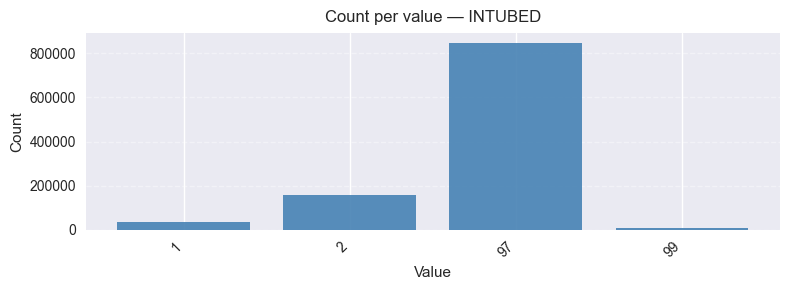

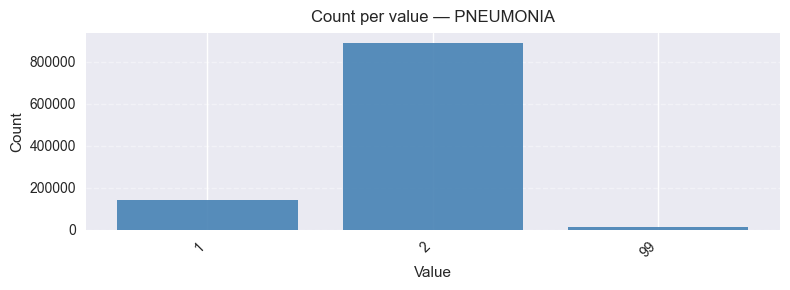

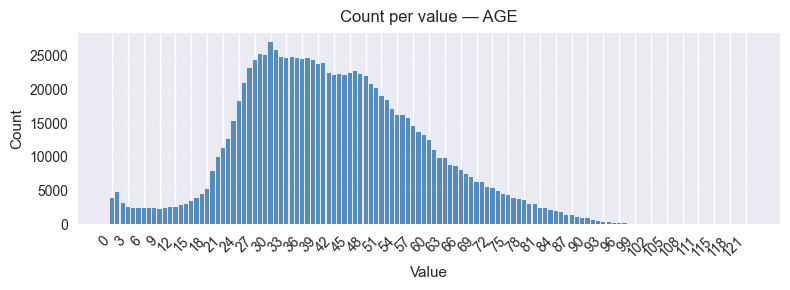

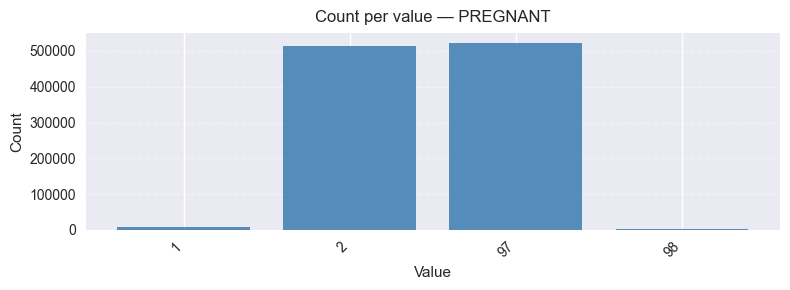

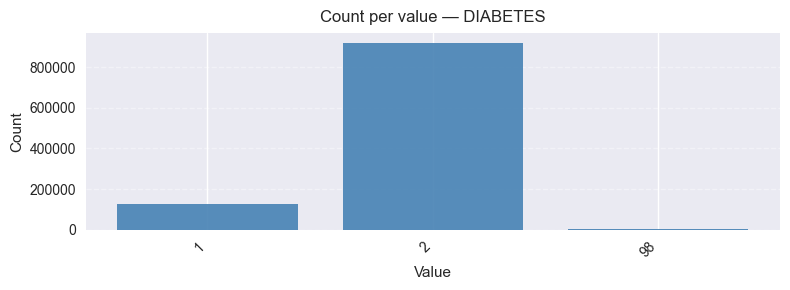

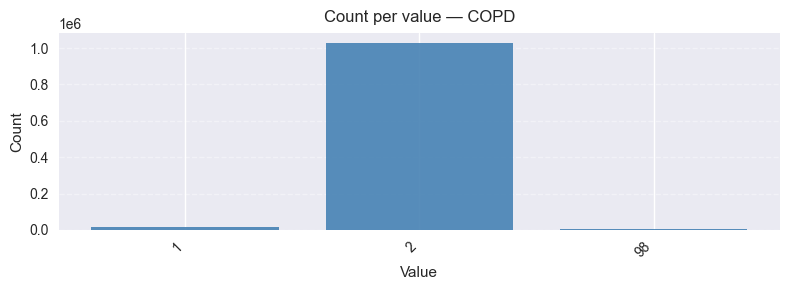

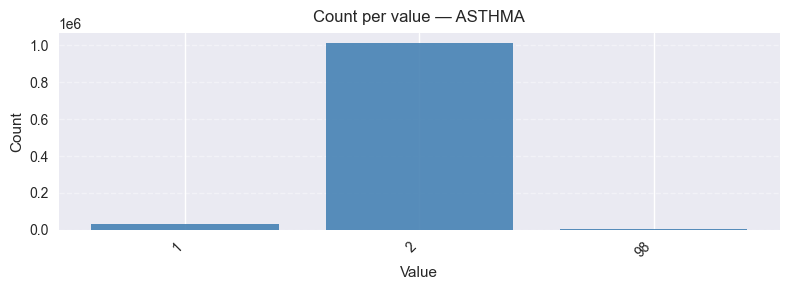

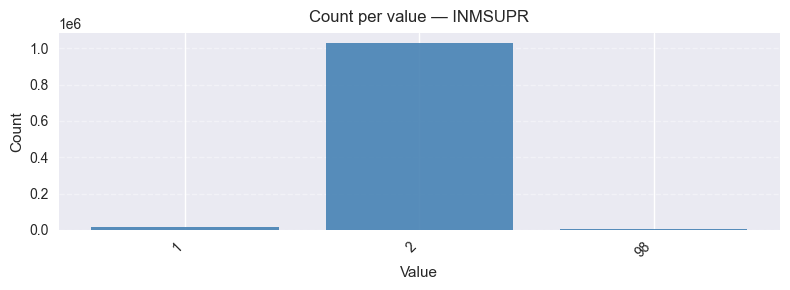

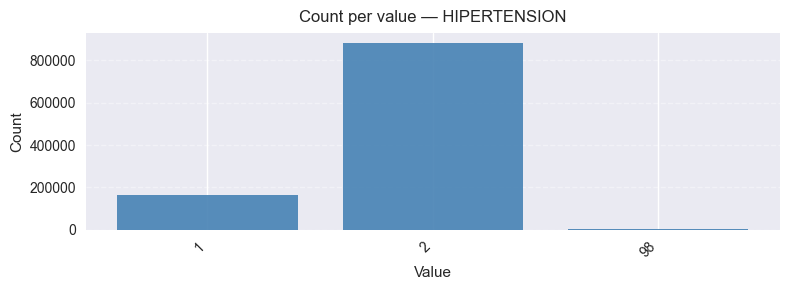

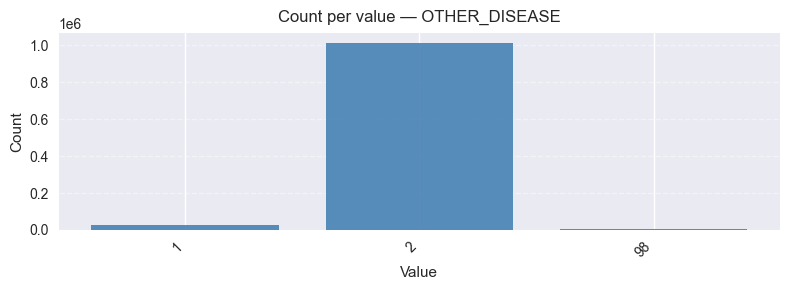

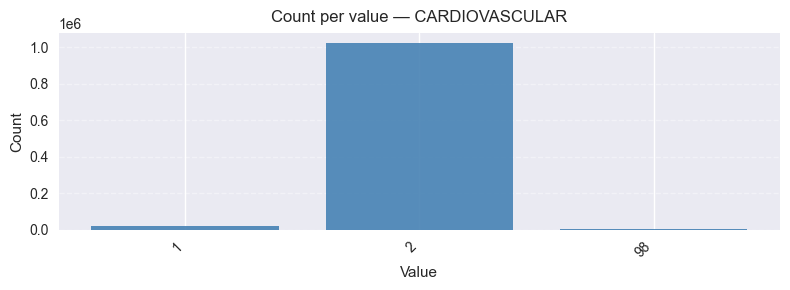

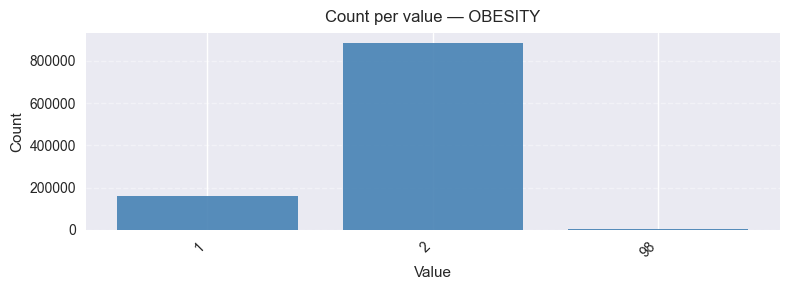

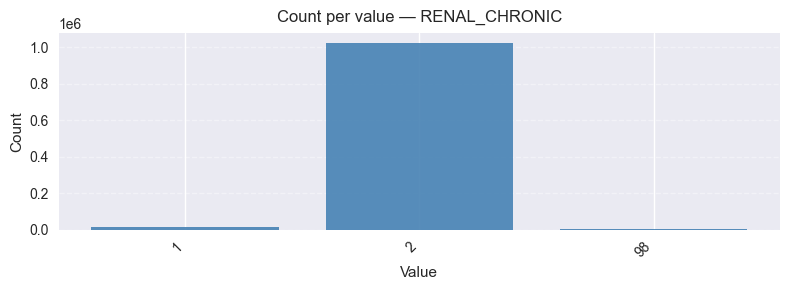

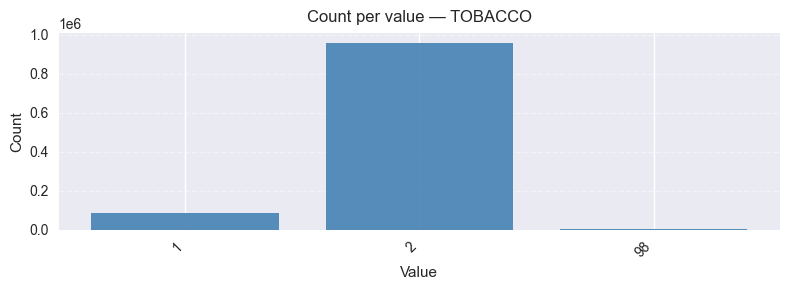

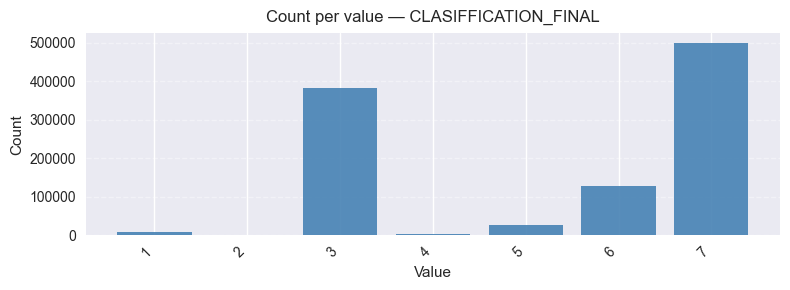

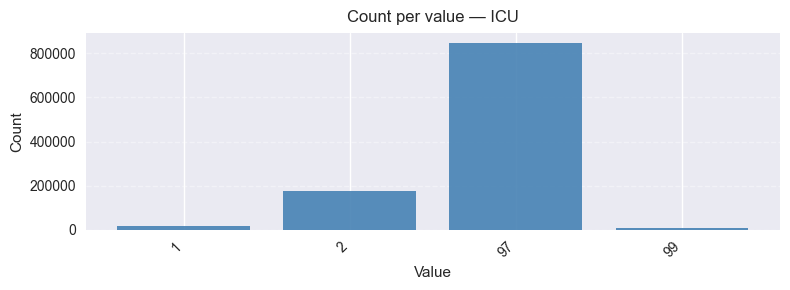

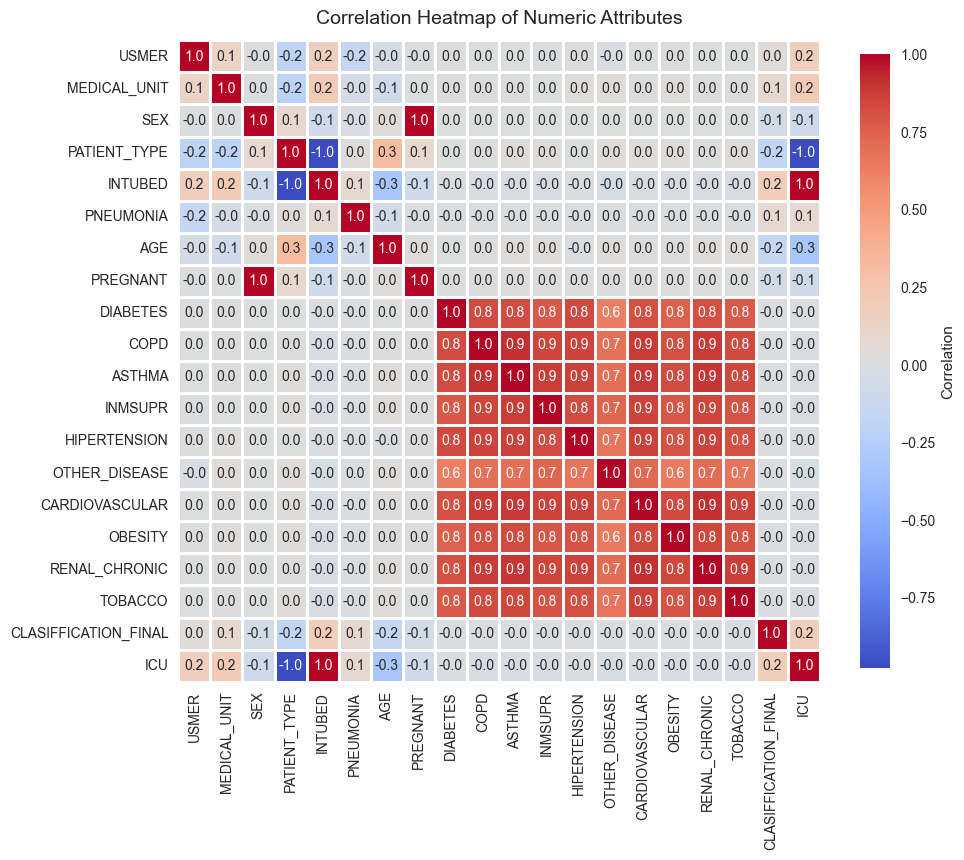

In [3]:
raw_df = pd.read_csv(DATA_PATH)
print(f"Shape of dataset: {raw_df.shape}")
display(raw_df.head())

numeric_df = raw_df.select_dtypes(include=["number"])

raw_df.info()
display(raw_df.count(numeric_only=True).to_frame(name="count"))
print("Dataset shape:", raw_df.shape)

for col in numeric_df.columns:
    series = numeric_df[col]
    counts = series.value_counts(dropna=False).sort_index()
    x = range(len(counts))
    labels = counts.index.astype(str)
    plt.figure(figsize=(8, 3))
    plt.bar(x, counts.values, color="steelblue", alpha=0.9, width=0.8)
    plt.title(f"Count per value — {col}", fontsize=12, pad=8)
    plt.xlabel("Value")
    plt.ylabel("Count")
    if len(labels) > 40:
        step = max(1, len(labels) // 40)
        plt.xticks(list(x)[::step], labels[::step], rotation=45, ha="right")
    else:
        plt.xticks(x, labels, rotation=45, ha="right")
    plt.grid(True, linestyle="--", axis="y", alpha=0.4)
    plt.tight_layout()
    plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".1f",
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)
plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
plt.tight_layout()
plt.show()


## Exploratory analysis


In [4]:
display(raw_df.describe(include='all').transpose())


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
USMER,1048575.0,NaN,NaN,NaN,1.632194,0.482208,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,1048575.0,NaN,NaN,NaN,8.980565,3.723278,1.0,4.0,12.0,12.0,13.0
SEX,1048575.0,NaN,NaN,NaN,1.499259,0.5,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1048575.0,NaN,NaN,NaN,1.190765,0.392904,1.0,1.0,1.0,1.0,2.0
DATE_DIED,1048575,401,9999-99-99,971633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INTUBED,1048575.0,NaN,NaN,NaN,79.522875,36.868886,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,1048575.0,NaN,NaN,NaN,3.346831,11.912881,1.0,2.0,2.0,2.0,99.0
AGE,1048575.0,NaN,NaN,NaN,41.794102,16.907389,0.0,30.0,40.0,53.0,121.0
PREGNANT,1048575.0,NaN,NaN,NaN,49.765585,47.510733,1.0,2.0,97.0,97.0,98.0
DIABETES,1048575.0,NaN,NaN,NaN,2.186404,5.424242,1.0,2.0,2.0,2.0,98.0


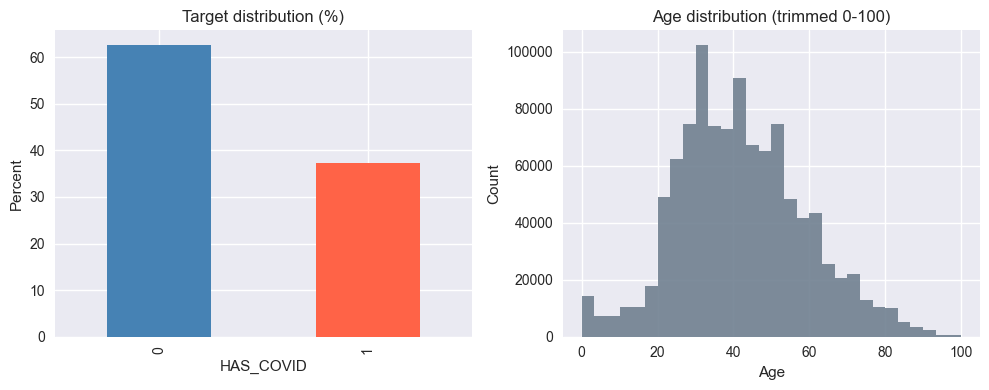

In [5]:
target_series = raw_df['CLASIFFICATION_FINAL'].isin([1, 2, 3]).astype(int)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
target_series.value_counts(normalize=True).mul(100).reindex([0, 1]).plot(
    kind='bar', ax=axes[0], color=['steelblue', 'tomato']
)
axes[0].set_title('Target distribution (%)')
axes[0].set_xlabel('HAS_COVID')
axes[0].set_ylabel('Percent')

age_sample = raw_df['AGE'].clip(0, 100)
axes[1].hist(age_sample, bins=30, color='slategray', alpha=0.9)
axes[1].set_title('Age distribution (trimmed 0-100)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


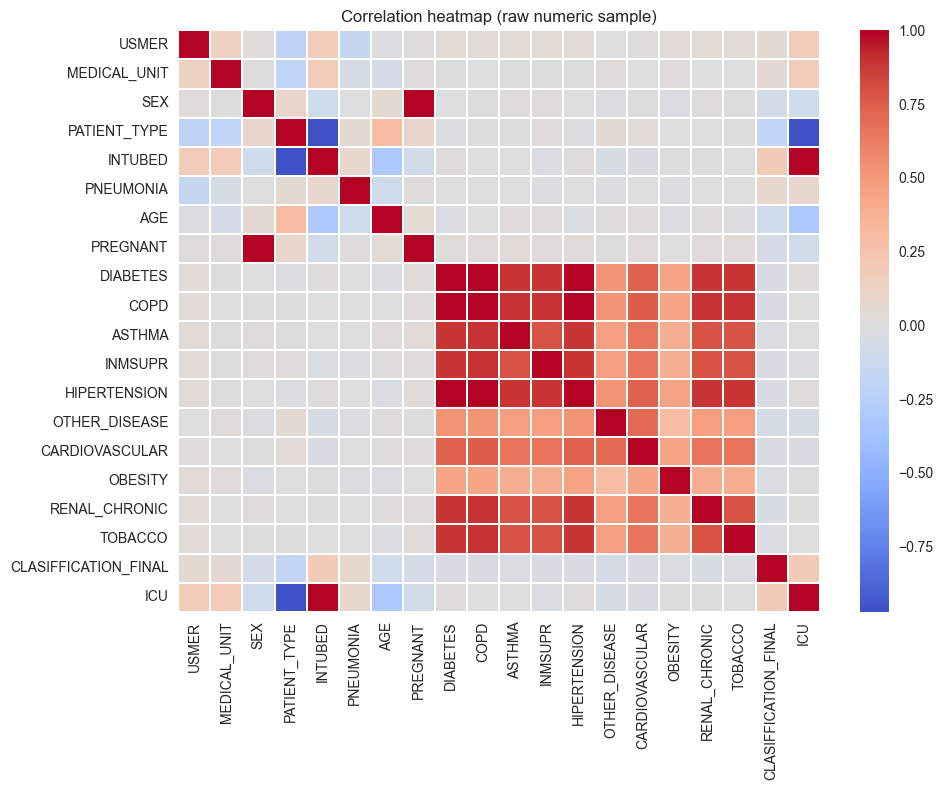

In [6]:
numeric_cols = raw_df.select_dtypes(include=['number']).columns
sample_for_corr = raw_df[numeric_cols].sample(n=min(2000, len(raw_df)), random_state=42)
plt.figure(figsize=(10, 8))
sns.heatmap(sample_for_corr.corr(), cmap='coolwarm', linewidths=0.1, center=0)
plt.title('Correlation heatmap (raw numeric sample)')
plt.tight_layout()
plt.show()


In [7]:
demo_df = raw_df.copy()
print('Sample before preprocessing:')
display(demo_df.iloc[:30])

demo_df.columns = demo_df.columns.str.strip()
demo_df.rename(columns={'DATE_DIED': 'DEAD'}, inplace=True)
med_unit_original = demo_df['MEDICAL_UNIT'].copy()
classif_original = demo_df['CLASIFFICATION_FINAL'].copy()

demo_df['DEAD'] = np.where(demo_df['DEAD'] == '9999-99-99', 2, 1)
demo_df.loc[demo_df['SEX'] == 1, 'PREGNANT'] = 0
binary_cols = ['USMER','SEX','INTUBED','PNEUMONIA','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','ICU','DEAD']
demo_df[binary_cols] = demo_df[binary_cols].replace(2, 0)
demo_df[binary_cols] = demo_df[binary_cols].replace(97, 0.5)
demo_df[binary_cols] = demo_df[binary_cols].replace(98, 0.5)
demo_df['MEDICAL_UNIT'] = med_unit_original
demo_df['CLASIFFICATION_FINAL'] = classif_original
demo_df.rename(columns={'SEX': 'IS_MALE'}, inplace=True)
demo_df['CLASIFFICATION_FINAL'] = demo_df['CLASIFFICATION_FINAL'].replace([1,2,3], 1)
demo_df['CLASIFFICATION_FINAL'] = demo_df['CLASIFFICATION_FINAL'].replace([4,5,6,7], 0)
demo_df.rename(columns={'CLASIFFICATION_FINAL': 'HAS_COVID'}, inplace=True)
print('Sample after key preprocessing steps:')
display(demo_df.iloc[:30])


Sample before preprocessing:


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


Sample after key preprocessing steps:


,USMER,MEDICAL_UNIT,IS_MALE,PATIENT_TYPE,DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HAS_COVID,ICU
0,0,1,1,1,1,0.5,1,65,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.5
1,0,1,0,1,1,0.5,1,72,0.5,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0.5
2,0,1,0,2,1,1.0,0,55,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3,0,1,1,1,1,0.5,0,53,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.5
4,0,1,0,1,1,0.5,0,68,0.5,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.5
5,0,1,1,2,0,0.0,1,40,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
6,0,1,1,1,0,0.5,0,64,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5
7,0,1,1,1,0,0.5,1,64,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.5
8,0,1,1,2,0,0.0,0,37,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0
9,0,1,1,2,0,0.0,0,25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


## Preprocessing


In [8]:
def preprocess_data(frame: pd.DataFrame) -> pd.DataFrame:
    df = frame.copy()
    df.columns = df.columns.str.strip()
    df.rename(columns={"SEX": "IS_MALE"}, inplace=True)
    valid = df["CLASIFFICATION_FINAL"].isin([1, 2, 3, 4, 5, 6])
    df = df.loc[valid].copy()

    df["DEAD"] = np.where(df["DATE_DIED"] == "9999-99-99", 0, 1)

    binary_cols = [
        "USMER",
        "IS_MALE",
        "INTUBED",
        "PNEUMONIA",
        "PREGNANT",
        "DIABETES",
        "COPD",
        "ASTHMA",
        "INMSUPR",
        "HIPERTENSION",
        "OTHER_DISEASE",
        "CARDIOVASCULAR",
        "OBESITY",
        "RENAL_CHRONIC",
        "TOBACCO",
        "ICU",
        "DEAD",
    ]
    replace_map = {1: 1, 2: 0, 3: np.nan, 97: np.nan, 98: np.nan, 99: np.nan}
    df[binary_cols] = df[binary_cols].replace(replace_map)
    df.loc[df["IS_MALE"] == 1, "PREGNANT"] = 0

    df["IS_HOSPITALIZED"] = df["PATIENT_TYPE"].map({1: 0, 2: 1}).fillna(0)
    df.drop(columns=["PATIENT_TYPE"], inplace=True)

    df["HAS_COVID"] = df["CLASIFFICATION_FINAL"].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})
    df.drop(columns=["CLASIFFICATION_FINAL", "DATE_DIED"], inplace=True)

    df[binary_cols] = df[binary_cols].fillna(df[binary_cols].median())

    risk_cols = [
        "DIABETES",
        "COPD",
        "ASTHMA",
        "INMSUPR",
        "HIPERTENSION",
        "OTHER_DISEASE",
        "CARDIOVASCULAR",
        "OBESITY",
        "RENAL_CHRONIC",
    ]
    df["CHRONIC_COUNT"] = df[risk_cols].sum(axis=1)
    df["MULTI_MORBID"] = (df["CHRONIC_COUNT"] >= 2).astype(int)
    df["RISK_OBESE_SMOKER"] = ((df["OBESITY"] == 1) | (df["TOBACCO"] == 1)).astype(int)

    df["AGE_BUCKET"] = (
        pd.cut(df["AGE"], bins=[0, 30, 45, 60, 75, 120], labels=False, include_lowest=True)
        .fillna(0)
        .astype(int)
    )

    scaler = StandardScaler()
    df["AGE"] = scaler.fit_transform(df[["AGE"]])

    df = pd.get_dummies(df, columns=["MEDICAL_UNIT"], prefix="MED_UNIT", drop_first=True)
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    return df


In [9]:
model_df = preprocess_data(raw_df)
print(f"Processed shape: {model_df.shape}")
display(model_df.head())
feature_cols = [col for col in model_df.columns if col != "HAS_COVID"]
print(f"Feature count: {len(feature_cols)}")


Processed shape: (549325, 36)


,USMER,IS_MALE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,...,MED_UNIT_4,MED_UNIT_5,MED_UNIT_6,MED_UNIT_7,MED_UNIT_8,MED_UNIT_9,MED_UNIT_10,MED_UNIT_11,MED_UNIT_12,MED_UNIT_13
0,0,1,0.0,1.0,1.262042,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0.0,1.0,1.676426,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,1.0,0.0,0.670064,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0.0,0.0,1.439635,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0,1,0.0,1.0,-0.217902,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


Feature count: 35


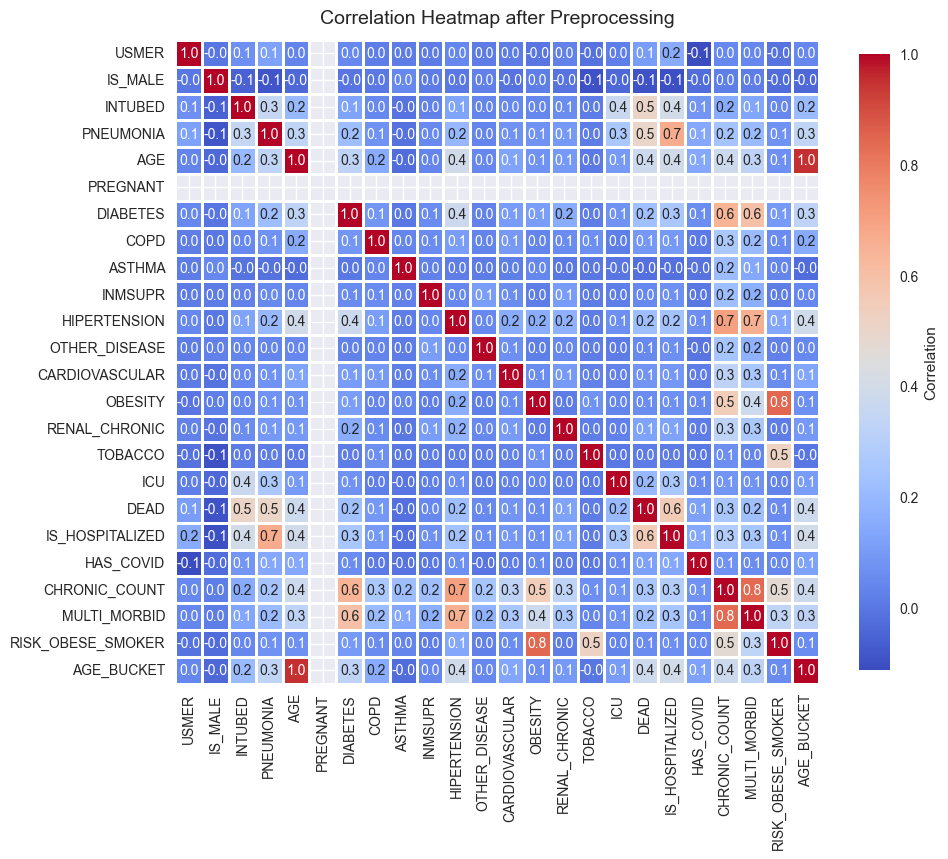

In [10]:
processed_numeric = model_df.select_dtypes(include=['number'])
corr_processed = processed_numeric.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_processed,
    annot=True,
    cmap='coolwarm',
    fmt='.1f',
    square=True,
    linewidths=1,
    cbar_kws={'shrink': 0.7, 'label': 'Correlation'}
)
plt.title('Correlation Heatmap after Preprocessing', fontsize=14, pad=12)
plt.tight_layout()
plt.show()


## Data split


In [11]:
train_df, temp_df = train_test_split(
    model_df,
    test_size=0.3,
    stratify=model_df["HAS_COVID"],
    random_state=42,
    shuffle=True,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=2 / 3,
    stratify=temp_df["HAS_COVID"],
    random_state=42,
    shuffle=True,
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

def describe_split(name, frame):
    share = frame["HAS_COVID"].mean() * 100
    print(f"{name:<10s} n={len(frame):,} | positive={share:.2f}% | negative={100 - share:.2f}%")

print("Dataset splits:")
describe_split("Train", train_df)
describe_split("Val", val_df)
describe_split("Test", test_df)


Dataset splits:
Train      n=384,527 | positive=71.36% | negative=28.64%
Val        n=54,932 | positive=71.36% | negative=28.64%
Test       n=109,866 | positive=71.36% | negative=28.64%


## Torch datasets


In [12]:
def frame_to_dataset(frame):
    features = frame[feature_cols].to_numpy(dtype=np.float32)
    labels = frame["HAS_COVID"].to_numpy(dtype=np.float32)
    return TensorDataset(torch.from_numpy(features), torch.from_numpy(labels))

train_dataset = frame_to_dataset(train_df)
val_dataset = frame_to_dataset(val_df)
test_dataset = frame_to_dataset(test_df)

class_counts = train_df["HAS_COVID"].value_counts().to_dict()
weights = train_df["HAS_COVID"].map(lambda value: 1.0 / class_counts[value]).to_numpy(dtype=np.float32)
sampler = WeightedRandomSampler(weights=torch.from_numpy(weights), num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

positive = float((train_df["HAS_COVID"] == 1).sum())
negative = float((train_df["HAS_COVID"] == 0).sum())
pos_weight_value = negative / max(positive, 1.0)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float32, device=device))

sample_batch = next(iter(train_loader))
print(f"Sample batch → X: {sample_batch[0].shape}, y: {sample_batch[1].shape}, pos_weight={pos_weight_value:.2f}")


Sample batch → X: torch.Size([1024, 35]), y: torch.Size([1024]), pos_weight=0.40


## Model and helpers


In [13]:
class CovidMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout):
        super().__init__()
        layers = []
        prev = input_dim
        for hidden in hidden_layers:
            layers.append(nn.Linear(prev, hidden))
            layers.append(nn.BatchNorm1d(hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = hidden
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)


def metrics_from_probs(probs, labels, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
        "pr_auc": average_precision_score(labels, probs),
    }
    prec_curve, rec_curve, _ = precision_recall_curve(labels, probs)
    mask = prec_curve >= 0.7
    metrics["recall_at_70_precision"] = float(rec_curve[mask].max()) if mask.any() else 0.0
    return metrics


def evaluate_model(model, loader):
    model.eval()
    losses, probs, labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item())
            probs.append(torch.sigmoid(logits).cpu())
            labels.append(yb.cpu())
    prob_array = torch.cat(probs).numpy()
    label_array = torch.cat(labels).numpy()
    metrics = metrics_from_probs(prob_array, label_array)
    metrics["roc_auc"] = roc_auc_score(label_array, prob_array)
    metrics["loss"] = float(np.mean(losses))
    return metrics, prob_array, label_array


def find_best_threshold(probs, labels):
    best_thr = 0.5
    best_score = 0.0
    for thr in np.linspace(0.1, 0.9, 17):
        score = f1_score(labels, (probs >= thr).astype(int), zero_division=0)
        if score > best_score:
            best_score = score
            best_thr = float(thr)
    return best_thr, best_score


In [14]:
def train_model(config):
    model = CovidMLP(len(feature_cols), config["hidden_layers"], config["dropout"]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)
    best_state = None
    best_snapshot = None
    best_score = -np.inf
    history = []
    for epoch in range(1, config["epochs"] + 1):
        model.train()
        epoch_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        val_metrics, val_probs, val_labels = evaluate_model(model, val_loader)
        scheduler.step(val_metrics["loss"])
        history.append(
            {
                "epoch": epoch,
                "train_loss": float(np.mean(epoch_losses)),
                **{k: v for k, v in val_metrics.items()},
            }
        )
        print(
            f"{config['name']:<10s} epoch {epoch:02d} "
            f"train_loss={history[-1]['train_loss']:.3f} val_loss={val_metrics['loss']:.3f} val_f1={val_metrics['f1']:.3f}"
        )
        if val_metrics["f1"] > best_score:
            best_score = val_metrics["f1"]
            best_state = deepcopy(model.state_dict())
            best_snapshot = (val_metrics.copy(), val_probs.copy(), val_labels.copy())
    model.load_state_dict(best_state)
    return model, history, best_snapshot


## Experiments


In [15]:
experiment_grid = [
    {"name": "baseline", "hidden_layers": [128, 64, 32], "dropout": 0.3, "lr": 3e-4, "weight_decay": 1e-4, "epochs": 10},
    {"name": "compact", "hidden_layers": [64, 32], "dropout": 0.25, "lr": 5e-4, "weight_decay": 5e-5, "epochs": 12},
    {"name": "wide", "hidden_layers": [256, 128, 64], "dropout": 0.4, "lr": 2e-4, "weight_decay": 1e-4, "epochs": 12},
]

experiment_results = []

for cfg in experiment_grid:
    model, history, snapshot = train_model(cfg)
    metrics_at_05, val_probs, val_labels = snapshot
    best_thr, _ = find_best_threshold(val_probs, val_labels)
    tuned_metrics = metrics_from_probs(val_probs, val_labels, threshold=best_thr)
    tuned_metrics["roc_auc"] = metrics_at_05["roc_auc"]
    tuned_metrics["loss"] = metrics_at_05["loss"]
    experiment_results.append(
        {
            "name": cfg["name"],
            "config": cfg,
            "state_dict": deepcopy(model.state_dict()),
            "threshold": best_thr,
            "val_metrics": tuned_metrics,
            "history": history,
        }
    )

results_table = pd.DataFrame(
    [
        {
            "experiment": result["name"],
            "val_f1": result["val_metrics"]["f1"],
            "val_pr_auc": result["val_metrics"]["pr_auc"],
            "val_recall_at_70_precision": result["val_metrics"]["recall_at_70_precision"],
            "threshold": result["threshold"],
        }
        for result in experiment_results
    ]
).sort_values(by="val_f1", ascending=False)

print("Validation summary:")
display(results_table.reset_index(drop=True))


baseline   epoch 01 train_loss=0.447 val_loss=0.388 val_f1=0.377
baseline   epoch 02 train_loss=0.395 val_loss=0.405 val_f1=0.280
baseline   epoch 03 train_loss=0.391 val_loss=0.408 val_f1=0.256
baseline   epoch 04 train_loss=0.389 val_loss=0.407 val_f1=0.264
baseline   epoch 05 train_loss=0.388 val_loss=0.407 val_f1=0.253
baseline   epoch 06 train_loss=0.388 val_loss=0.407 val_f1=0.249
baseline   epoch 07 train_loss=0.388 val_loss=0.407 val_f1=0.253
baseline   epoch 08 train_loss=0.388 val_loss=0.407 val_f1=0.246
baseline   epoch 09 train_loss=0.388 val_loss=0.406 val_f1=0.255
baseline   epoch 10 train_loss=0.387 val_loss=0.407 val_f1=0.247
compact    epoch 01 train_loss=0.409 val_loss=0.403 val_f1=0.271
compact    epoch 02 train_loss=0.390 val_loss=0.403 val_f1=0.254
compact    epoch 03 train_loss=0.388 val_loss=0.404 val_f1=0.251
compact    epoch 04 train_loss=0.386 val_loss=0.403 val_f1=0.255
compact    epoch 05 train_loss=0.386 val_loss=0.402 val_f1=0.253
compact    epoch 06 train

,experiment,val_f1,val_pr_auc,val_recall_at_70_precision,threshold
0,baseline,0.838837,0.832810,1.0,0.15
1,compact,0.838304,0.836349,1.0,0.10
2,wide,0.837906,0.833826,1.0,0.10


In [ ]:
history_metrics = ["train_loss", "loss", "f1"]
for result in experiment_results:
    history_df = pd.DataFrame(result["history"])
    plt.figure(figsize=(7, 4))
    for metric in history_metrics:
        if metric in history_df.columns:
            plt.plot(history_df["epoch"], history_df[metric], label=metric.replace("_", " "))
    plt.title(f"Training history - {result['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Test evaluation


Test metrics with tuned threshold:
  loss: 0.3890
  roc_auc: 0.6873
  pr_auc: 0.8310
  accuracy: 0.7294
  precision: 0.7320
  recall: 0.9794
  f1: 0.8378
  recall_at_70_precision: 1.0000
Classification report:
              precision    recall  f1-score   support

         0.0     0.6748    0.1067    0.1842     31470
         1.0     0.7320    0.9794    0.8378     78396

    accuracy                         0.7294    109866
   macro avg     0.7034    0.5430    0.5110    109866
weighted avg     0.7156    0.7294    0.6506    109866

Confusion matrix:


,Pred 0,Pred 1
Actual 0,3357,28113
Actual 1,1618,76778


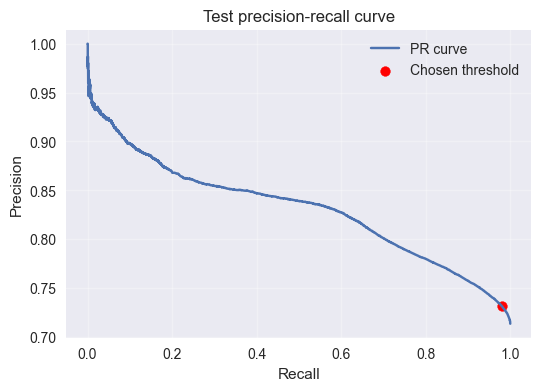

In [16]:
best_experiment = max(experiment_results, key=lambda item: item["val_metrics"]["f1"])
best_cfg = best_experiment["config"]
best_threshold = best_experiment["threshold"]

best_model = CovidMLP(len(feature_cols), best_cfg["hidden_layers"], best_cfg["dropout"]).to(device)
best_model.load_state_dict(best_experiment["state_dict"])

test_metrics_raw, test_probs, test_labels = evaluate_model(best_model, test_loader)
test_metrics = metrics_from_probs(test_probs, test_labels, threshold=best_threshold)
test_metrics["roc_auc"] = test_metrics_raw["roc_auc"]
test_metrics["loss"] = test_metrics_raw["loss"]

print("Test metrics with tuned threshold:")
for key in ["loss", "roc_auc", "pr_auc", "accuracy", "precision", "recall", "f1", "recall_at_70_precision"]:
    print(f"  {key}: {test_metrics[key]:.4f}")

binary_preds = (test_probs >= best_threshold).astype(int)
print("Classification report:")
print(classification_report(test_labels, binary_preds, digits=4, zero_division=0))

cm = confusion_matrix(test_labels, binary_preds)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion matrix:")
display(cm_df)

precisions, recalls, _ = precision_recall_curve(test_labels, test_probs)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(test_metrics["recall"], test_metrics["precision"], color="red", label="Chosen threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test precision-recall curve")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
